In [1]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


# Dataprep with Dask
Goals:
- query and prep data
- Load in and save data into user scratch or some other spot

In [3]:
# 1. Get EASI Defaults
easi = EasiDefaults()
bucket = easi.scratch

# 2. Get User ID
userid = boto3.client('sts').get_caller_identity()['UserId']

# 3. Define your Project Name and Dataset Name
project_name = "traning_test_project"
dataset_name = "training_dataset_v1.zarr"

# 4. Construct the full S3 Path
# This is where Dask will write the files
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

print(f"Target Storage Path: {s3_path}")

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/traning_test_project/training_dataset_v1.zarr


For stuff like loading in data, we don't need GPUs yet so this should be ok

In [4]:
gateway = Gateway()
options = gateway.cluster_options()

clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)


cluster.scale(4)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)


Creating new cluster...
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.e0a56ac16fb44d2289ed626c5a02aa70/status


Task exception was never retrieved
future: <Task finished name='Task-449' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-447' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


In [7]:
from pystac_client import Client as StacClient

In [8]:
# from datacube.utils.masking import describe_variable_flags

# # # Print the available flags for the fmask band
# # import pandas as pd

# # # Show all rows and columns
# # pd.set_option("display.max_rows", None)
# # pd.set_option("display.max_columns", None)
# # pd.set_option("display.width", None)
# # pd.set_option("display.max_colwidth", None)

# # # Now print the flags
# # describe_variable_flags(ds.fmask)
dc = datacube.Datacube()
# So workers can access AWS
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

In [7]:
# Get the centroid of the coordinates of the default extents
central_lat = sum(easi.latitude)/2
central_lon = sum(easi.longitude)/2
# central_lat = -42.019
# central_lon = 146.615

# Set the buffer to load around the central coordinates
# This is a radial distance for the bbox to actual area so bbox 2x buffer in both dimensions
buffer = 0.8

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Data product
products = easi.product('landsat')

# Set the date range to load data over
set_time = easi.time
set_time = (set_time[0], parse(set_time[0]) + relativedelta(years=1))
# set_time = ("2021-01-01", "2021-12-31")

# ------------------------ Measurment choice -----------------
# Selected measurement names (used in this notebook). None` will load all of them
alias = easi.aliases('landsat')
#all_measurements = list(alias.values())
#print(f"{alias.keys()}")

target_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']


spectral_measurements = [alias[k] for k in target_keys]
#measurements = [alias['red'], alias['green'], alias['blue'], qa_band]
# measurements = [alias[x] for x in ['qa_band', 'red', 'nir']]

# Set the QA band name and mask values
qa_band = alias['qa_band']
qa_mask = easi.qa_mask('landsat')

measurements = spectral_measurements + [qa_band]

# Set the resampling method for the bands
resampling = {qa_band: "nearest", "*": "average"}

# Set the coordinate reference system and output resolution
set_crs = easi.crs('landsat')  # If defined, else None
set_resolution = easi.resolution('landsat')  # If defined, else None
# set_crs = "epsg:3577"
# set_resolution = (-30, 30)

# Set the scene group_by method
group_by = "solar_day"

In [8]:
label_product = 'ga_ls_landcover_class_cyear_3'
label_measurement = 'level3'

dataset = None # clear results from any previous runs
dataset = dc.load(
            product=products,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling=resampling,
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = {"time":1, "x":2048, "y":2048},
            group_by=group_by,
        )
print(f"dataset size (GiB) {dataset.nbytes / 2**30:.2f}")
# --- NEW: LOAD AND ALIGN LABELS ---

# 1. Load label data broadly using the initial time range (required by dc.load)
labels_broad_ds = dc.load(
    product=label_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time, # Must use start/end date format
    measurements=[label_measurement],
    resampling={"*": "nearest"}, # Labels must use nearest neighbor resampling
    output_crs=set_crs,
    resolution=set_resolution,
    dask_chunks = {"time":1, "x":2048, "y":2048}, # Use same I/O chunking
    group_by=group_by,
)

# 2. Align labels onto the exact time dimension of the Landsat input
labels_ds = labels_broad_ds.reindex_like(
    dataset, 
    method='nearest' # Force alignment to nearest composite map time
)

print(f"Label data successfully aligned. Total scenes: {labels_ds.time.size}")


# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = masking.make_mask(dataset[qa_band], **qa_mask)
# Separate the bands we want to TRAIN on (RGB)
# Drop the QA band now, we don't feed it to the model.
training_ds = dataset[spectral_measurements]

# Apply Mask: Use , 0 to replace clouds with Black. 
# Default .where() creates NaNs, which break PyTorch.
ds_masked = training_ds.where(cloud_free_mask, 0)


# Landsat is Int16 (0-10,000). Normalize to Float32 (0-1).
ds_norm = ds_masked.astype('float32') / 10000.0

# Convert Dictionary (Dataset) to Block (DataArray)
# This stacks Red/Green/Blue into a new dimension 'band'
ds_final = ds_norm.to_array(dim='band')

# 1. Extract the aligned label array
labels_da = labels_ds[label_measurement]

# Inspect nodata value if present
print("Label attrs:", labels_da.attrs)
print("Label encoding:", labels_da.encoding)

# 2. Map nodata (if any) to 255, but DO NOT apply the Landsat cloud mask
nodata = labels_da.attrs.get("nodata", None)
if nodata is None:
    nodata = labels_da.encoding.get("_FillValue", None)

if nodata is not None:
    labels_clean = labels_da.where(labels_da != nodata, 255)
else:
    labels_clean = labels_da  # assume all values are valid classes

# 3. Convert to final format (Int64 is required for PyTorch class indices)
labels_final = labels_clean.astype("int64")
training_ds_combined = xr.Dataset(
    {
        'features': ds_final,
        'labels': labels_final
    }
)

# Rechunk for Training
ds_final = training_ds_combined.chunk({'time': 1, 'x': 224, 'y': 224})

print("Data Pipeline Ready:")
ds_final

dataset size (GiB) 18.34
Label data successfully aligned. Total scenes: 43
Label attrs: {'units': '1', 'nodata': 255, 'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}
Label encoding: {}
Data Pipeline Ready:


<xarray.Dataset> Size: 48GB
Dimensions:      (time: 43, y: 6441, x: 5469, band: 6)
Coordinates:
  * time         (time) datetime64[ns] 344B 2020-02-08T23:56:31.774346 ... 20...
  * y            (y) float64 52kB -3.922e+06 -3.922e+06 ... -4.115e+06
  * x            (x) float64 44kB 1.272e+06 1.272e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int32 4B 3577
  * band         (band) object 48B 'nbart_blue' 'nbart_green' ... 'nbart_swir_2'
Data variables:
    features     (band, time, y, x) float32 36GB dask.array<chunksize=(1, 1, 224, 224), meta=np.ndarray>
    labels       (time, y, x) int64 12GB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>

In [20]:
import planetary_computer
# Your specific area & time
bbox = [145.815, -42.819, 147.415, -41.219] # Central Tasmania
time_range = "2021-01-01/2021-12-31"

# --- 2. SEARCH (STAC) ---
catalog = StacClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace # SIGN ITEMS AUTOMATICALLY
)

print("Searching for Sentinel-2 L2A...")
s2_items = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    # Filter for low cloud cover to avoid garbage data
    query={"eo:cloud_cover": {"lt": 50}} 
).item_collection()

print(f"Found {len(s2_items)} Sentinel-2 scenes.")

print("Searching for WorldCover...")
label_items = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox
).item_collection()

# --- 3. LOAD & ALIGN ---

# Band Mapping for Prithvi (S2 L2A names on MPC)
# Note: 'SCL' is the Scene Classification Layer (like 'qa')
bands_s2 = {
    "B02": "blue", 
    "B03": "green", 
    "B04": "red", 
    "B8A": "nir",   # Use B8A (Narrow NIR) for Prithvi consistency
    "B11": "swir1", 
    "B12": "swir2", 
    "SCL": "qa"     # Sentinel Classification Layer
}

# Config: Sentinel-2 is 10m/20m/60m. Prithvi wants 30m (HLS) but works fine at 20m.
# Let's load at 20m resolution (standard for S2 SWIR bands).
resolution = 20 
crs = "EPSG:32755" # UTM Zone 55S (Native for Tasmania) OR "EPSG:3577" (Albers)

# A. Load Imagery
ds = odc.stac.load(
    s2_items,
    bands=bands_s2,
    bbox=bbox,
    chunks={"x": 2048, "y": 2048, "time": 1},
    resolution=resolution,
    crs=crs,
    groupby="solar_day",
    fail_on_error=False,
    # MPC Patching is usually handled by 'planetary_computer' modifier above
)

# B. Load Labels (Aligned to S2 grid)
labels = odc.stac.load(
    label_items,
    bands=["map"],
    geobox=ds.odc.geobox, # Force alignment
    chunks={"x": 2048, "y": 2048, "time": 1},
    resampling="nearest",
    fail_on_error=False
)

# --- 4. PRE-PROCESS (Offset & Masking) ---

# Sentinel-2 L2A on MPC is already offset-corrected in metadata, 
# but let's ensure we get float reflectance (0.0 - 1.0).
# SCL Mask: 0=NoData, 1=Saturated, 3=Cloud Shadow, 8-10=Cloud/Cirrus
# Valid Land: 4, 5, 6, 7 (Veg, Bare, Water, Unclassified)
# We mask out clouds (values 3, 8, 9, 10)
qa = ds['SCL']
valid_mask = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7)

# Normalize: S2 data is typically UInt16 (0-10000).
# Prithvi expects 0-1 float.
# 1. Normalize and Create Features Stack
features = ds[['B02', 'B03', 'B04', 'B8A', 'B11', 'B12']].where(valid_mask, 0)
features = features.rename({
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B8A': 'nir',
    'B11': 'swir1',
    'B12': 'swir2'
})
features = features.astype("float32") / 10000.0 

# Stack into (band, time, y, x)
features_stack = features.to_array(dim="band", name="features")

# 2. Broadcast Labels (Using a band that definitely exists in 'ds')
# We use 'B02' because 'blue' does not exist in 'ds'.
# Alternatively, we could use features['blue'] which DOES exist.
labels_map = labels['map'].isel(time=0, drop=True)
labels_expanded = labels['map'].broadcast_like(ds['B02']) # <--- FIXED: used 'B02' instead of 'blue'

# 3. Combine
# Note: features_stack is already a DataArray, so we don't call to_array() again inside Dataset
train_ds = xr.Dataset({
    "features": features_stack,
    "labels": labels_expanded
}).chunk({"x": 1024, "y": 1024, "time": 1})

print(f"Pipeline Ready. Size: {train_ds.nbytes / 1e9:.2f} GB")

Searching for Sentinel-2 L2A...
Found 503 Sentinel-2 scenes.
Searching for WorldCover...
Pipeline Ready. Size: 197.51 GB


In [10]:
client.restart()

In [11]:
import planetary_computer
from pystac_client import Client
import odc.stac
import xarray as xr
import numpy as np
import boto3
import dask
from dask_gateway import Gateway
from easi_tools import EasiDefaults


# --- S3 SETUP ---
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v1.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")

# --- CONFIGURATION ---
locations = {
    "tasmania_forest":   [146.5, -42.0, 146.7, -41.8],
    "vic_agriculture":   [143.5, -37.0, 143.7, -36.8],
    "nsw_coast":         [150.8, -34.5, 151.0, -34.3],
    "qld_tropical":      [145.7, -16.5, 145.9, -16.3],
    "wa_arid":           [116.0, -32.0, 116.2, -31.8]
}

seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]
resolution = 20
output_crs = "EPSG:3577"

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)


def process_location(loc_name, bbox):
    """Process a single location - runs on distributed workers."""
    
    try:
        # Load labels
        label_items = catalog.search(
            collections=["esa-worldcover"], 
            bbox=bbox
        ).item_collection()
        
        labels = odc.stac.load(
            label_items, 
            bands=["map"], 
            bbox=bbox, 
            chunks={"x": 512, "y": 512},
            resolution=resolution, 
            crs=output_crs, 
            resampling="nearest", 
            fail_on_error=False
        )
        target_geobox = labels.odc.geobox
        
        # Load each time step
        time_steps = []
        
        for time_range in seasonal_windows:
            s2_items = catalog.search(
                collections=["sentinel-2-l2a"], 
                bbox=bbox, 
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}} 
            ).item_collection()
            
            if not s2_items:
                return None

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=target_geobox,
                chunks={"x": 512, "y": 512},
                fail_on_error=False
            )
            
            if ds.sizes['time'] == 0:
                return None
            
            # Cloud-free composite (stays lazy)
            if 'SCL' in ds:
                qa = ds['SCL']
                valid_mask = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                ds_masked = ds.where(valid_mask)
                composite = ds_masked.median(dim="time")
                fallback = ds.min(dim="time")
                composite = composite.fillna(fallback).fillna(0)
            else:
                composite = ds.median(dim="time").fillna(0)
            
            time_steps.append(composite)

        if len(time_steps) != 3:
            return None

        # Stack time steps
        stacked = xr.concat(time_steps, dim="time")
        
        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            'B02': 'blue', 'B03': 'green', 'B04': 'red',
            'B8A': 'nir', 'B11': 'swir1', 'B12': 'swir2'
        })
        features = features.astype("float32") / 10000.0
        features_da = features.to_array(dim="band").transpose("time", "band", "y", "x")
        
        labels_da = labels['map'].isel(time=0, drop=True)
        
        return xr.Dataset({
            "features": features_da,
            "labels": labels_da
        })
        
    except Exception as e:
        print(f"Error processing {loc_name}: {e}")
        return None


# --- BUILD LAZY COMPUTATION GRAPH ---
print("\nBuilding computation graph...")

lazy_datasets = []
for loc_name, bbox in locations.items():
    print(f"  Adding: {loc_name}")
    ds = dask.delayed(process_location)(loc_name, bbox)
    lazy_datasets.append(ds)

# --- EXECUTE ON DISTRIBUTED WORKERS ---
print("\nExecuting on distributed workers...")
print("(Watch progress on dashboard)")

results = dask.compute(*lazy_datasets)

# Filter failures
valid_datasets = [ds for ds in results if ds is not None]
print(f"\nProcessed: {len(valid_datasets)}/{len(locations)} locations")

if not valid_datasets:
    raise RuntimeError("No valid datasets!")

# --- COMBINE ---
print("\nCombining samples...")

for i, ds in enumerate(valid_datasets):
    valid_datasets[i] = ds.expand_dims({"sample": [i]})

ds_final = xr.concat(valid_datasets, dim="sample")

ds_final = ds_final.chunk({
    "sample": 1,
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224
})

ds_final.attrs["n_samples"] = len(valid_datasets)
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print(f"\nDataset structure:")
print(f"  features: {dict(ds_final['features'].sizes)}")
print(f"  labels:   {dict(ds_final['labels'].sizes)}")

# --- SAVE TO S3 ---
print(f"\nWriting to {s3_path}...")
ds_final.to_zarr(s3_path, mode='w', consolidated=True)

print(f"\n[DONE] Saved to S3.")
print("Pipeline complete.")

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr

Building computation graph...
  Adding: tasmania_forest
  Adding: vic_agriculture
  Adding: nsw_coast
  Adding: qld_tropical
  Adding: wa_arid

Executing on distributed workers...
(Watch progress on dashboard)

Processed: 5/5 locations

Combining samples...


/tmp/ipykernel_105/3573861579.py:161: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(valid_datasets, dim="sample")
/tmp/ipykernel_105/3573861579.py:161: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(valid_datasets, dim="sample")
/env/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of ch


Dataset structure:
  features: {'sample': 5, 'time': 3, 'band': 6, 'y': 6036, 'x': 5288}
  labels:   {'sample': 5, 'y': 6036, 'x': 5288}

Writing to s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr...


/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 151.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



[DONE] Saved to S3.
Pipeline complete.


In [15]:
# Fixed an error in the Zar encoding, time already has units or something i guess?
#train_ds.time.attrs.pop('units', None)

task = train_ds.to_zarr(s3_path, mode='w', consolidated=True, compute=False)

print("Graph built. Submitting to cluster...")

dask.compute(task)



/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Graph built. Submitting to cluster...


/env/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 44.65 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(None,)

In [9]:
# Check
ds = xr.open_dataset(s3_path, engine='zarr')
print(ds)

<xarray.Dataset> Size: 198GB
Dimensions:      (band: 6, time: 118, y: 8913, x: 6707)
Coordinates:
  * band         (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 944B 2020-01-01 ... 2021-12-30T00:02:4...
  * x            (x) float64 54kB 4.007e+05 4.007e+05 ... 5.348e+05 5.348e+05
  * y            (y) float64 71kB 5.437e+06 5.437e+06 ... 5.259e+06 5.259e+06
Data variables:
    features     (band, time, y, x) float32 169GB ...
    labels       (time, y, x) float32 28GB ...


⏳ Verifying Saved Data at: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v1.zarr
Dataset loaded. Dimensions:
  Samples (N): 5
  Time Steps (T): 3
  Spatial (Y, X): 6036, 5288
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
Processing Sample 0...
Processing Sample 1...
Processing Sample 2...
Processing Sample 3...
Processing Sample 4...


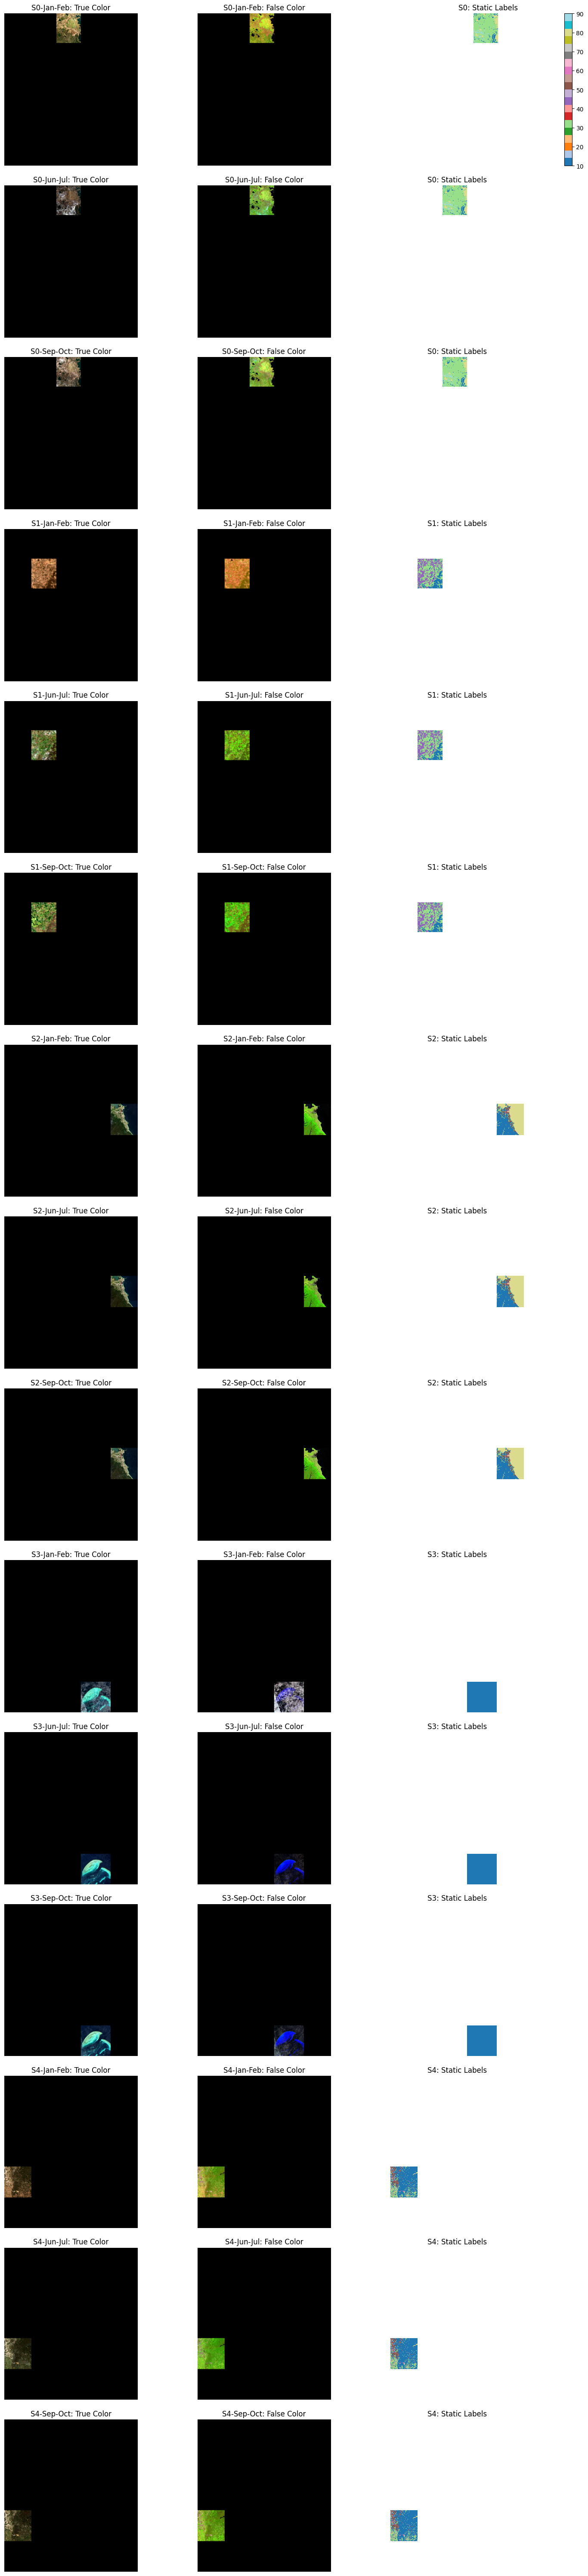

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import dask.distributed

# --- CONFIGURATION ---
# The s3_path from the saving notebook should be used here.
# Example: s3_zarr_path = s3_path
s3_zarr_path = s3_path # Ensure this variable is accessible/set

print(f"⏳ Verifying Saved Data at: {s3_zarr_path}")

# --- 1. Load Data (Distributively if needed) ---
# Use Dask for loading to match the environment, although 'chunks={}' will load
# the metadata and index the chunks for all workers.
try:
    # Set up S3 access
    fs = s3fs.S3FileSystem()
    store = s3fs.S3Map(root=s3_zarr_path, s3=fs, check=False)
    
    # Open the multi-sample Zarr store. 'chunks={}' loads the full dataset chunks
    # lazily without combining them into a single dask chunk.
    ds = xr.open_dataset(store, engine='zarr', chunks={}) 
except Exception as e:
    print(f"⚠️ Error loading Zarr: {e}")
    raise

features = ds['features']
labels = ds['labels']

num_samples = features.sizes['sample'] # Check the new 'sample' dimension size
n_time_steps = features.sizes['time']  # Check the 'time' dimension size
print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = ds.attrs["bands"] # Retrieve band names from dataset attributes
print(f"  Bands: {band_names}")

def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming 'band' is a dimension.
    Input data_array is expected to be (T, B, Y, X)
    """
    stack = []
    for b in bands_list:
        # Select band across all time steps
        band_data = data_array.sel(band=b) 
        stack.append(band_data)
        
    # Stack along a new 'color' dimension, then transpose to (T, Y, X, Color)
    img = xr.concat(stack, dim="color").transpose('time', 'y', 'x', 'color').values.astype('float32')
    img = np.nan_to_num(img, nan=0.0)
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None # Signal that all images in this sample are invalid
        
    # Contrast Stretch - apply stretching to each time step independently
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(num_samples):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where((label_np == 0) | (label_np == 255), label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

In [1]:
client.close()
cluster.shutdown()

NameError: name 'client' is not defined